<a href="https://colab.research.google.com/github/yanos84/Tutorials/blob/main/Hugging_Face_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Before we start loading models from Hugging Face or working with frameworks like LangChain, Llama, or Nemotron, it is essential to check whether our system has access to a GPU. Large language models rely heavily on parallel computations, and running them on a CPU can be extremely slow or even impossible for bigger models.

PyTorch provides simple tools to detect if CUDA is installed, whether the GPU is visible, and what GPU model is available. Knowing this information helps us choose the right model size and the correct configuration (such as FP16, 8-bit, or 4-bit quantization). It also helps prevent common errors like “CUDA out of memory” or “No GPU found” before they happen.

The following small code block performs three basic checks:

* whether CUDA is available on the machine,

* what GPU model PyTorch can access,

* and how many GPUs are detected.

This is a standard first step before working with modern LLMs, because it ensures that the environment is correctly set up for fast inference.

In [1]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")
print("Number of GPUs:", torch.cuda.device_count())

CUDA available: True
GPU name: Tesla T4
Number of GPUs: 1


By running these three lines, we make sure that:

* PyTorch is correctly installed,

* CUDA is working,

* and the system is ready to load models like Llama, Nemotron, or any Hugging Face Transformer.

This avoids many common errors and helps you select the right model size and precision in the next steps of the tutorial.

Before we start building applications with Hugging Face and large language models such as Llama or Nemotron, we need to install the core Python libraries that will allow us to download models, preprocess data, run inference efficiently, and interact with the Hugging Face Hub.
These libraries form the foundation of the entire workflow: they handle tokenization, dataset loading, GPU acceleration, evaluation metrics, and communication with your Hugging Face account.
The following command installs all the essential tools we will use throughout this tutorial.

In [2]:
!pip install transformers datasets accelerate evaluate huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.2 MB/s eta 0:00:00


Here is what each of these packages does and why we need them:

1. transformers

        This is the main Hugging Face library.
        It provides:
        * thousands of pretrained models (Llama, Nemotron, BERT, GPT-like models…)
        * tokenizers
        * pipelines for text generation, classification, QA, etc.
        This is the core tool for loading and running modern LLMs.


---

2. datasets

        A high-performance library for loading and manipulating datasets.
        It supports:
        * huge datasets (streaming, memory-efficient)
        * many formats (CSV, JSON, Parquet, Hugging Face Hub datasets)
        * automatic train/validation/test splits
        Useful for training, fine-tuning, and evaluation.


---

3. accelerate

        A library that helps run models efficiently on:
        * GPUs,
        * multiple GPUs,
        * or across distributed systems.
        It automatically manages device placement, mixed precision (fp16, bf16), and speed optimizations.
        We need it especially for larger models or fine-tuning.


---
4. evaluate

        A library that provides many standard NLP metrics.  Useful when measuring model performance or comparing different model outputs.
---
5. huggingface_hub

        It's the “connection” between your local machine and Hugging Face.

# Simple model depolyment

Before working with large models such as Llama or Nemotron, it is always a good idea to test our environment using a very small and lightweight transformer. This helps confirm that the Hugging Face transformers library is correctly installed, that pipelines work as expected, and that basic inference runs without errors.

In the following example, we load a tiny sentiment-analysis model from Hugging Face (DistilBERT) and run a simple test to verify that everything is functioning. This step is like a “health check” for your environment before moving on to bigger models.

In [ ]:
from transformers import pipeline

def test_small_transformer():
    # Load a small transformer model for testing
    nlp = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

    # Test the model with a sample input
    result = nlp("I love using transformers library!")

    # Check if the output is as expected
    assert result[0]['label'] == 'POSITIVE'
    assert result[0]['score'] > 0.9
    return result

if __name__ == "__main__":
    print(test_small_transformer())
    print("Small transformer test passed.")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


[{'label': 'POSITIVE', 'score': 0.9989345669746399}]
Small transformer test passed.


This script performs a simple diagnostic to ensure that the `transformers` library and inference pipeline are running correctly. The `pipeline` function is one of the easiest ways to use pretrained models.
It hides the complexity of tokenization, model loading, and tensor handling.

After verifying that our environment works with a small sentiment-analysis model, we can move to another basic but very common task: text generation.
Hugging Face provides an extremely easy way to generate text using the pipeline API.
Here, we will use GPT-2, a lightweight autoregressive language model that can run almost anywhere (CPU or GPU).

This step helps students understand how text-generation works before using more advanced models such as Llama, Nemotron, or any modern LLM.

In [ ]:
from transformers import pipeline

def test_text_generation():
    # Load a small text-generation model
    generator = pipeline("text-generation", model="gpt2")

    # Generate text from an initial prompt
    output = generator("Laghouat mornings feel", max_length=100)

    return output

if __name__ == "__main__":
    print(test_text_generation())
    print("Text generation test passed.")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


[{'generated_text': "Laghouat mornings feel like the 'horses of the world' for a change. The city has witnessed a change in the way people live, the way the city has grown and the way they work.\n\nIn the city, there is no place like home. There are no places like this for the people who work there, to live their lives. The people who work there are not just the people who live there, they're the people who run the city.\n\nYou know, they were never going to be happy in the world. They were never going to be happy in their country. The people who work there were never going to be happy in their country. The people who run the city are the people who run the city.\n\nThis is why the city needs to take a very, very serious look at its future. Because the people who live in the city are the people who live in the city. They are the people who run the city.\n\nAt the end of this interview, we'll talk about what it takes to get the city to be where it is today.\n\n(Visited 1591 times, 1 vis

# Fine-Tuning a Vision Transformer (ViT) Locally

In this section, we will take a small Vision Transformer (ViT) model and train it on a simple medical-image classification task.


## Download A dataset

We start by getting the  [Chest X-Ray Images (Pneumonia)](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia) from Kaggle

In [3]:
from datasets import load_dataset
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'chest-xray-pneumonia' dataset.
Path to dataset files: /kaggle/input/chest-xray-pneumonia


In [4]:
!cp -r /kaggle/input/chest-xray-pneumonia /content

In [7]:
#!rm -R /content/chest-xray-pneumonia/chest_xray/__MACOSX
!rm -R /content/chest-xray-pneumonia/chest_xray/chest_xray

In [14]:
dataset = load_dataset("imagefolder", data_dir="/content/chest-xray-pneumonia/chest_xray")

Resolving data files:   0%|          | 0/5216 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/624 [00:00<?, ?it/s]

We download the vision transformer `vit-base-patch16-224-in21k` which is a lightweight model trained on `ImageNet-21k` and is fast to fine-tune on a single GPU.

But befor that, make sure to have the latest version of transformers:

## Preprocessing step

Before training a Vision Transformer (ViT), we need to convert raw images from our dataset (JPEG, PNG, etc.) into the correct numerical format expected by the model.

Hugging Face provides an Image Processor (here: ViTImageProcessor) that handles:

* resizing images to the model’s required size

* normalizing pixel values

* converting them to PyTorch tensors

* packaging them with labels



In [24]:
!pip install transformers datasets timm torch torchvision

In [25]:
import os
from torchvision import datasets, transforms

data_dir = "/content/chest-xray-pneumonia/chest_xray"

transform = transforms.Compose([
    transforms.Resize((224, 224)),   # ViT expects 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # grayscale normalization
])

train_dataset = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=transform)
val_dataset   = datasets.ImageFolder(os.path.join(data_dir, "val"), transform=transform)
test_dataset  = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=transform)


ViT expects 224×224 images. PyTorch models expect tensors, not PIL images. So, images should be normalized (mean/std scaling) for better training.
`datasets.ImageFolder` is a  `PyTorch` utility apllied to automatically label images based on folder names.

It applies the transform to each image on the fly when accessed.

We, next,  chose Vision Transformer (ViT) from Hugging Face:

In [26]:
from transformers import ViTForImageClassification, ViTImageProcessor

model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=2,   # Normal vs Pneumonia
    id2label={0: "NORMAL", 1: "PNEUMONIA"},
    label2id={"NORMAL": 0, "PNEUMONIA": 1}
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 we use `d2label` to map numeric predictions to class names for easier interpretation and  `label2id` to map class names back to integers, needed during training. The following step is to use `DataLoader` as follows:

In [27]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32)

## Training Step

We fine-tune the ViT on the  dataset using PyTorch’s training loop. First, we pass the model to the available device (the GPU)

In [28]:
import torch
from torch import nn, optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Epoch 1, Loss: 0.0530
Epoch 2, Loss: 0.0059
Epoch 3, Loss: 0.0041


Next, fix some hyperparameters (Cross entropy for binary classification and Adam for backpropagation) and we execute small a training (3epochs):

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=5e-5)

for epoch in range(3):  # adjust epochs
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

We can evaluate the model on the validation dataset (which is small)

In [36]:
'''model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"Validation Accuracy: {100 * correct / total:.2f}%")'''


Validation Accuracy: 100.00%


We perform the same transformations to the testing set and we compute the test accuracy:

Test Accuracy: 79.65%


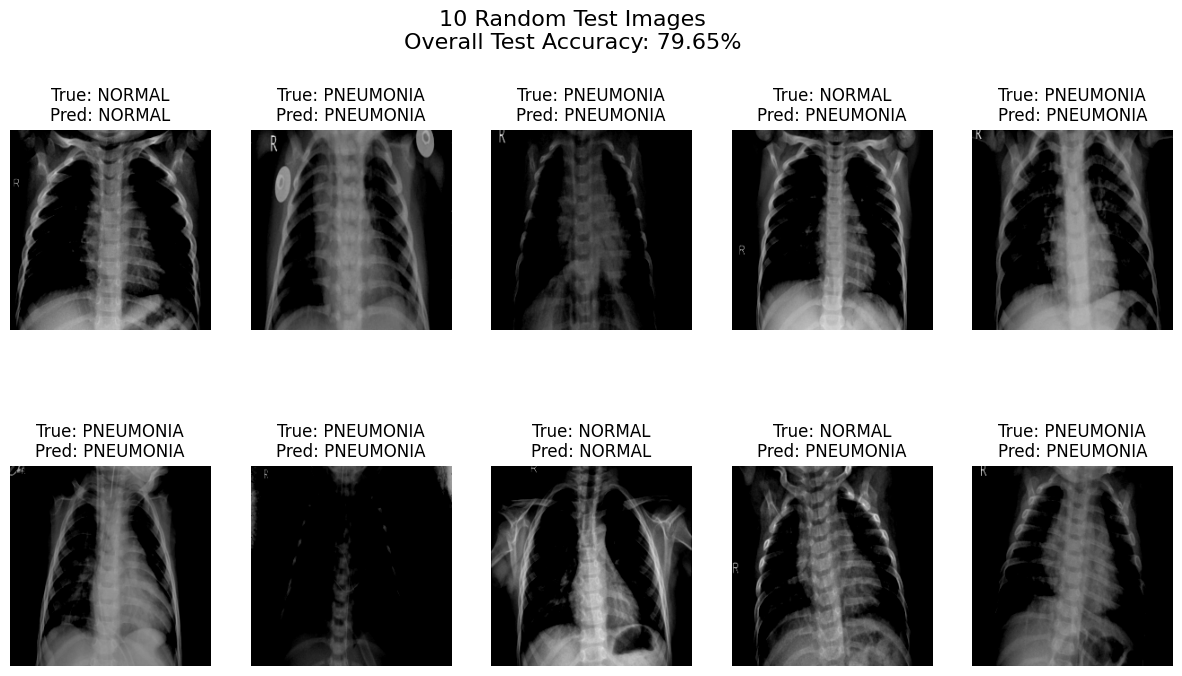

In [35]:
import os
import random
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torch

# Path to test folder
test_dir = "/content/chest-xray-pneumonia/chest_xray/test"

# Transform (resize to 224x224 for ViT)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # normalize grayscale
])

# Load test dataset
test_dataset = datasets.ImageFolder(test_dir, transform=transform)
class_names = test_dataset.classes  # ['NORMAL', 'PNEUMONIA']

# DataLoader
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# --- Compute Test Accuracy ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()
model.to(device)

correct, total = 0, 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = 100 * correct / total
print(f"Test Accuracy: {test_acc:.2f}%")


Here, we plot 10 randomly images and we compare true and predicted labels:

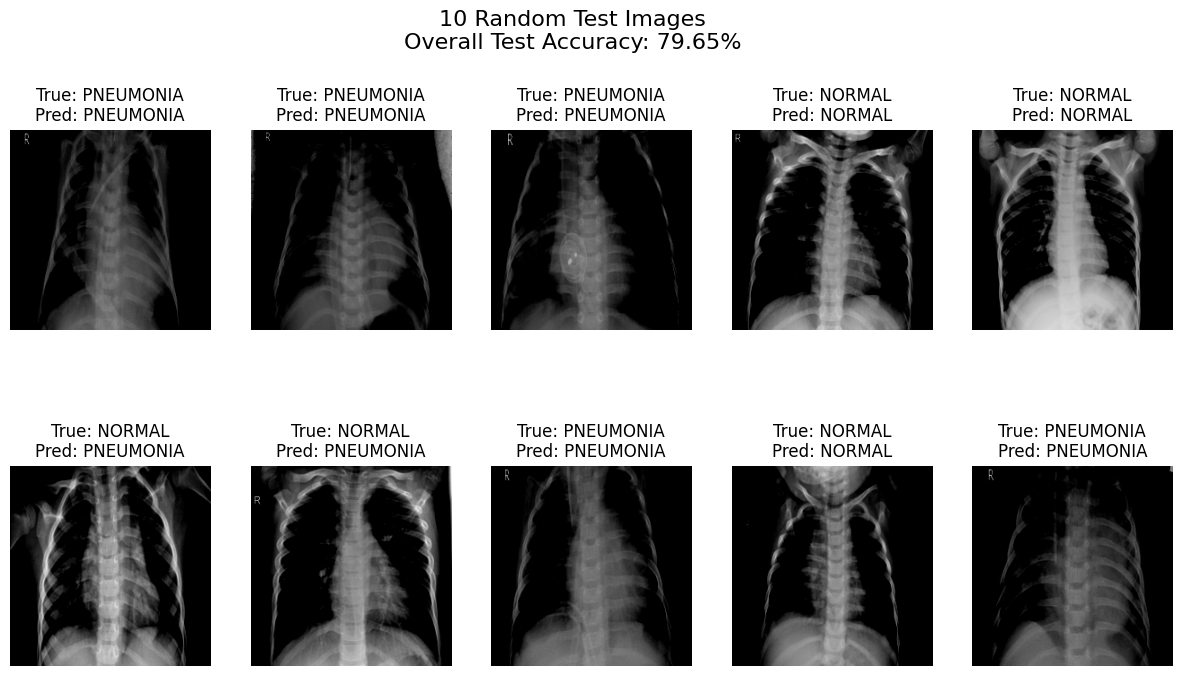

In [39]:
# --- Plot 10 Random Test Images with True + Predicted Labels ---
indices = random.sample(range(len(test_dataset)), 10)

plt.figure(figsize=(15, 8))
for i, idx in enumerate(indices):
    image, label = test_dataset[idx]
    # Add batch dimension and send to device
    img_input = image.unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img_input).logits
        pred = torch.argmax(output, dim=1).item()

    plt.subplot(2, 5, i+1)
    plt.imshow(image.permute(1, 2, 0), cmap="gray")
    plt.title(f"True: {class_names[label]}\nPred: {class_names[pred]}")
    plt.axis("off")

plt.suptitle(f"10 Random Test Images\nOverall Test Accuracy: {test_acc:.2f}%", fontsize=16)
plt.show()


## Freezing layers

We can choose to freeze all the layers and train only the last classification layer:

In [ ]:
# Freeze all parameters except the classification head
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the classifier head
for param in model.classifier.parameters():
    param.requires_grad = True

We can also choose what layers to freeze:

In [ ]:
def freeze_vit_layers(model, freeze_until: int):
    """
    Freeze all encoder layers up to 'freeze_until' index.
    Example: freeze_until=9 → freeze layers 0..9, keep 10..11 trainable.
    """
    # Freeze embeddings if desired
    for param in model.vit.embeddings.parameters():
        param.requires_grad = False

    # Freeze encoder layers up to freeze_until
    for i, layer in enumerate(model.vit.encoder.layer):
        if i <= freeze_until:
            for param in layer.parameters():
                param.requires_grad = False

    # Always keep classifier head trainable
    for param in model.classifier.parameters():
        param.requires_grad = True

# Example usage: freeze first 9 layers, train last 3 + classifier
freeze_vit_layers(model, freeze_until=8)



---



---
# Simple Local RAG

We will learn how to make an offline question-answering system that reads  PDF files and answers questions based on them. The system will load  PDFs, split them into small parts, convert these parts into vector embeddings, store them in a Chroma database, and finally use a local Mistral-7B model to answer  questions.

## Required libraries

First, we install necessary libraries:

In [ ]:
!pip install langchain==0.1.0 pypdf chromadb

Next, we import the libraries that we need.

In [ ]:
import os
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain.chains import RetrievalQA   # <-- use langchain, not langchain_community
from langchain.llms import HuggingFacePipeline
from transformers import pipeline
from langchain_community.vectorstores import Chroma

## Documents preprocessing

The next step is to load all PDF files from a folder. Every PDF inside the folder will be processed.

In [ ]:
# 1. Load all PDFs
base_path = "/content/pdfs"

docs = []
for filename in os.listdir(base_path):
    if filename.endswith(".pdf"):
        loader = PyPDFLoader(os.path.join(base_path, filename))
        docs.extend(loader.load())
print(f"Loaded {len(docs)} documents from {base_path}")

After loading the documents, we split them into smaller text chunks. A chunk is simply a piece of text cut from your original document. This is necessary because language models cannot handle large text all at once.

In [ ]:
# 2. Split into chunks
splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
chunks = splitter.split_documents(docs)
print(f"Split into {len(chunks)} chunks")

Now we create embeddings using a small and fast local model. These embeddings are numerical vectors that represent the meaning of each chunk.

In [ ]:
# 3. Embeddings (local, no token required)
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

`all-MiniLM-L6-v2` is a much more modern and powerful type of model called a Transformer-based sentence embedding model. Unlike word2vec, it creates an embedding for whole sentences or paragraphs and is thus much more accurate for semantic search

## Store embeddings vectors

Vectors are lists of numbers that represent the meaning of text in a mathematical form. When we convert a text chunk into an embedding, we turn it into a vector such as [0.12, -0.55, 0.87, …]. These numbers allow a computer to compare meanings: if two chunks talk about the same idea, their vectors will be close to each other in this multi-dimensional space. Because computers cannot search meaning directly from text, they search through these vectors instead. This is why semantic search becomes possible only after converting text into vectors.

We use Chroma because it is a fast, simple, and fully local database designed specifically to store and search these vectors. When we ask a question, Chroma quickly finds the most similar vector to the question’s embedding, which means it finds the most relevant chunk of text from the PDFs. It also stores data on disk, so we can reuse our vector store without rebuilding it every time.

Chunks were divided into batches simply to avoid memory problems. If you try to insert thousands of chunks into Chroma at once, especially on a machine with limited RAM, the process can crash or slow down dramatically. By dividing the chunks into batches (for example 5000 at a time), we allow the computer to process smaller pieces safely, keeping the system stable and preventing memory overload.

In [ ]:
# 4. Vector store with batching
batch_size = 5000
vectorstore = None

for i in range(0, len(chunks), batch_size):
    batch = chunks[i:i+batch_size]
    if vectorstore is None:
        vectorstore = Chroma.from_documents(batch, embeddings, persist_directory="./chroma_store")
    else:
        vectorstore.add_documents(batch)

print("Vector store built successfully")

## Loading Q/A model

The next step is to load the local language model. Here we use `Mistral-7B-Instruct`, which works well for question answering (not very good).

In [ ]:
# 5. Local LLM (no token required)
llm_pipeline = pipeline(
    "text-generation",
    model="mistralai/Mistral-7B-Instruct-v0.2",   # lightweight model
    device_map="auto",
    max_length=512,
    temperature=0.1,
)
llm = HuggingFacePipeline(pipeline=llm_pipeline)

We use `device_map` to choose the best available hardware, such as a GPU if one exists. The parameter `max_length` controls how long the model’s output can be, measured in tokens (small pieces of text). The parameter `temperature` controls how creative or deterministic the model is. A low value like 0.1 makes the model very focused, factual, and stable, producing almost the same answer every time. A high `temperature` would make the model more creative but also less reliable for precise question-answering.

## Chain connection
We then connect the vector database with the model using a RetrievalQA chain. This chain retrieves the most relevant chunks and gives them to the model to answer the question.

In [ ]:
# 6. RetrievalQA chain
qa = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=vectorstore.as_retriever()
)

## Ask a question

In [ ]:
print(qa.run("What topics are covered in the folder?"))